# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a tensor flow based deep learning classifier is built to classify the trafic signs.


---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# Loading data files

training_file = './traffic-signs-data/train.p'
validation_file= './traffic-signs-data/valid.p'
testing_file =  './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
import numpy as np

# Number of training examples
n_train = y_train.shape[0]

# Number of validation examples
n_validation = y_valid.shape[0]

# Number of testing examples.
n_test = y_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = (X_train.shape[1], X_train.shape[2])

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

38


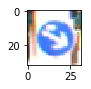

In [3]:
import matplotlib.pyplot as plt
import random

# Visualizations will be shown in the notebook.
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [4]:
### Preprocess the data here. It is required to normalize the data. 
X_train = (X_train - 128.0)/ 128.0
X_test = (X_test - 128.0)/ 128.0
X_valid = (X_valid - 128.0)/ 128.0

## Shuffle data

### Model Architecture

In [5]:
### Lenet architecture is built.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def max_pool(x, k=2, stride=2):
    ksize = [1, k, k, 1]
    strides = [1, stride, stride, 1]
    padding = 'VALID'
    return tf.nn.max_pool(x, ksize, strides, padding)

global layer1 ## globalizing for visualization
global layer2 ## globalizing for visualization
def LeNet(x):
    global layer1
    global layer2
    mu = 0
    sigma = 0.1
    
    weights = {
    'wc1': tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma)), ## convolution layer
    'wc2': tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma)), ## convolution layer
    'wd1': tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma)), ## fully connected layer
    'wd2': tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma)), ## fully connected layer
    'out': tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma)) ## output layer
    }

    biases = {
    'bc1': tf.Variable(tf.zeros([6])),
    'bc2': tf.Variable(tf.zeros([16])),
    'bd1': tf.Variable(tf.zeros([120])),
    'bd2': tf.Variable(tf.zeros([84])),
    'out': tf.Variable(tf.zeros([n_classes]))
    }
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    layer1 = conv2d(x, weights['wc1'], biases['bc1'], strides=1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    layer1 = max_pool(layer1)

    # Layer 2: Convolutional. Output = 10x10x16.
    layer2 = conv2d(layer1, weights['wc2'], biases['bc2'], strides=1)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    layer2 = max_pool(layer2)

    # Flatten. Input = 5x5x16. Output = 400.
    layer2_flatten = flatten(layer2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    layer3 = tf.add(tf.matmul(layer2_flatten, weights['wd1']), biases['bd1'])
    
    # Activation.
    layer3 = tf.nn.relu(layer3)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    layer4 = tf.add(tf.matmul(layer3, weights['wd2']), biases['bd2'])
    
    # Activation.
    layer4 = tf.nn.relu(layer4)
    
    # Layer 5: Fully Connected. Input = 84. Output = 10.
    layer5 = tf.add(tf.matmul(layer4, weights['out']), biases['out'])
    
    return layer5

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [6]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

In [7]:
### Train model here.
### Calculate and report the accuracy on the training and validation set.

rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Evaluation

In [8]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Training

In [9]:
from sklearn.utils import shuffle

EPOCHS = 10
BATCH_SIZE = 128

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet_trafficSign_classifier')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.753

EPOCH 2 ...
Validation Accuracy = 0.843

EPOCH 3 ...
Validation Accuracy = 0.874

EPOCH 4 ...
Validation Accuracy = 0.896

EPOCH 5 ...
Validation Accuracy = 0.894

EPOCH 6 ...
Validation Accuracy = 0.899

EPOCH 7 ...
Validation Accuracy = 0.904

EPOCH 8 ...
Validation Accuracy = 0.911

EPOCH 9 ...
Validation Accuracy = 0.908

EPOCH 10 ...
Validation Accuracy = 0.914

Model saved


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Selecting 5 random images from the test images
### Load the images and plot them here.

import csv

label=[]
ifile = open('signnames.csv', 'r')
reader = csv.reader(ifile)
for i,row in enumerate(reader):
    if i==0: continue
    label.append(row[1])
            
indices=[]
for i in range(5):
    indices.append(random.randint(0, len(X_test)))
    
image = X_test[indices].squeeze()

#plt.figure(figsize=(1,1))
gt = []
plt.figure()
for i in range(5):
    plt.subplot(1, 5, i+1)
    gt.append(label[y_test[indices[i]]])
    plt.imshow(image[i], cmap='gray')

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./lenet_trafficSign_classifier.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    result = []
    model_input = np.zeros([1,32,32,3])
    for i in range(5):
        model_input[0,:,:,:] = image[i]
        out = sess.run(tf.argmax(logits, 1), feed_dict={x: model_input})
        result.append(label[int(out)])

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
accuracy = 0
for i in range(5):
    if result[i]==gt[i]: 
        accuracy += 1
accuracy /= 5.0 
print("Accuracy for the 5 sampled images is:", accuracy*100, "%")

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In the following, for each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limited the output to the top 5 probabilities for each image). 

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./lenet_trafficSign_classifier.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    result = []
    model_input = np.zeros([1,32,32,3])
    for i in range(5):
        model_input[0,:,:,:] = image[i]
        out = sess.run(tf.nn.top_k(logits, k=5), feed_dict={x: model_input})
        plt.figure(i)
        plt.subplot(1,5,1)
        plt.imshow(image[i], cmap='gray')
        plt.show()
        print("True label is:")
        print("* -", gt[i])
        print("Top 5 guesses are:")
        for j in range(5):
            print(j+1, "- ", label[int(out.indices[0][j])])

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is an excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training the neural network we can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

The following function allows to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process.

In [ ]:

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

In [ ]:
### Visualize network's feature maps here.

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./lenet_trafficSign_classifier.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    model_input = np.zeros([1,32,32,3])
    model_input[0,:,:,:] = image[3]
    tf_activation = layer1
    outputFeatureMap(model_input, tf_activation)

In [ ]:
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./lenet_trafficSign_classifier.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    model_input = np.zeros([1,32,32,3])
    model_input[0,:,:,:] = image[3]
    tf_activation = layer2
    outputFeatureMap(model_input, tf_activation, plt_num=1)